In [2]:
import json
import numpy as np
import pandas as pd
FILE_NAME = 'D:/simulator/MARL/data/final_adjusted_coord.json'
with open(FILE_NAME,'r') as f:
    raw_traj = json.load(f)['raw_traj']
processed_traj = [[] for _ in range(4)]
for ind,sub in enumerate(raw_traj):
    for line in sub:
        processed_traj[ind].append(np.array(line)+ np.array([839,480])+np.array([-10,-10]))


In [13]:
def load_holding_point():
    FILE_NAME = 'D:/simulator/MARL/data/holding_point.json'
    with open(FILE_NAME,'r') as f:
        holding_point = json.load(f)['holding_point']
    return holding_point

def traj_preprocessing(traj,holding_index ,radius_time):
    if radius_time == 0:
        return traj
    #for mutiple circle delay
    traj = np.array(traj)
    speed = np.sqrt(np.sum((traj[holding_index] -traj[holding_index-2])**2))
    radius = speed*radius_time/(4*np.pi)
    direction = traj[holding_index] -traj[holding_index-4]
    unit = (direction/np.linalg.norm(direction, axis=0))*radius
    center= np.empty_like(direction)
    center[0] = -unit[1]
    center[1] = unit[0]
    center = center + traj[holding_index]
    #angle = self.rotate_circle(center[0],center[1])
    theta = np.linspace(0, 2*np.pi, int(radius_time))
    x1 = -radius*np.cos(theta)+center[0]   #anticlock-wise
    x2 = -radius*np.sin(theta)+center[1]
    circle = np.stack((x1,x2),axis = 1)     # create the figure
    dis = np.sum((circle - traj[holding_index])**2,axis = 1)
    start_indx = np.argmin(dis)
    circle = np.vstack((circle[start_indx+1::],circle[:start_indx]))
    #circle = np.tile(circle,(delay_round,1))
    final_traj = np.vstack((traj[:holding_index+1],circle,traj[holding_index+1::]))
    return final_traj

In [14]:
def init_timeline():
    FILE_NAME = 'D:/simulator/MARL/data/timeline_cutoff.json'
    with open(FILE_NAME,'r') as f:
        cutoff_point = json.load(f)['cut_off']
    return cutoff_point
cutoff_point = init_timeline()

In [57]:
import copy
holding_point = load_holding_point()
TRAIN_X,TRAIN_Y = [],[]
for ind,i in enumerate(processed_traj):
    for indx,j in enumerate(i):
        for delay in range(0,10):
            traj = traj_preprocessing(copy.deepcopy(j),holding_point[ind][indx],delay*60)
            cutoff = cutoff_point[ind][indx]+delay*60
            for frame in range(cutoff):
                TRAIN_X.append([traj[frame][0]/500,traj[frame][1]/500,ind+1,frame/60,delay])#x,y,delaytime,entry port,pasted time
                TRAIN_Y.append((cutoff-frame)/60)
                

In [58]:
X,Y = copy.deepcopy(TRAIN_X),copy.deepcopy(TRAIN_Y)

In [59]:
import tensorflow as tf
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled

array([[-2.58455047,  1.06307512, -0.83975315, -1.57841329, -1.69610178],
       [-2.57918312,  1.06358016, -0.83975315, -1.57638187, -1.69610178],
       [-2.57387967,  1.06406898, -0.83975315, -1.57435045, -1.69610178],
       ...,
       [ 0.10201155, -0.09986951,  1.59240822,  1.30214226,  1.45920102],
       [ 0.10127636, -0.09810594,  1.59240822,  1.30417368,  1.45920102],
       [ 0.10054118, -0.09635855,  1.59240822,  1.30620511,  1.45920102]])

In [71]:
np.array(X).shape

(1318590, 5)

In [77]:
def classifier():
    model = tf.keras.models.Sequential()
    model.add( tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(5,)))
    
    model.add( tf.keras.layers.Dense(8, activation=tf.nn.relu))
    #model.add(tf.keras.layers.Dropout(0.5))
    #model.add( tf.keras.layers.Dense(4, activation=tf.nn.relu))
    model.add( tf.keras.layers.Dense(1))
    return model
model = classifier()
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

In [78]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 16)                96        
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 9         
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [79]:
X_scaled = X_scaled.reshape(-1,5)
model.fit(X_scaled,Y,epochs=10, shuffle=True,validation_split=0.2, batch_size=256)

Train on 1054872 samples, validate on 263718 samples
Epoch 1/10
1054872/1054872 [==============================] - 4s 4us/sample - loss: 2.9868 - val_loss: 0.6714
Epoch 2/10
1054872/1054872 [==============================] - 4s 4us/sample - loss: 2.5454 - val_loss: 0.5772
Epoch 3/10
1054872/1054872 [==============================] - 4s 4us/sample - loss: 2.4769 - val_loss: 1.2516
Epoch 4/10
1054872/1054872 [==============================] - 4s 4us/sample - loss: 2.4471 - val_loss: 1.1784
Epoch 5/10
1054872/1054872 [==============================] - 4s 4us/sample - loss: 2.4279 - val_loss: 1.1291
Epoch 6/10
1054872/1054872 [==============================] - 4s 4us/sample - loss: 2.4234 - val_loss: 1.6248
Epoch 7/10
1054872/1054872 [==============================] - 4s 4us/sample - loss: 2.4252 - val_loss: 1.3014
Epoch 8/10
1054872/1054872 [==============================] - 4s 4us/sample - loss: 2.4109 - val_loss: 1.6124
Epoch 9/10
1054872/1054872 [==============================] - 4s 4u

In [80]:
abs_error = model.predict(X_scaled).reshape(-1) - np.array(Y).reshape(-1)

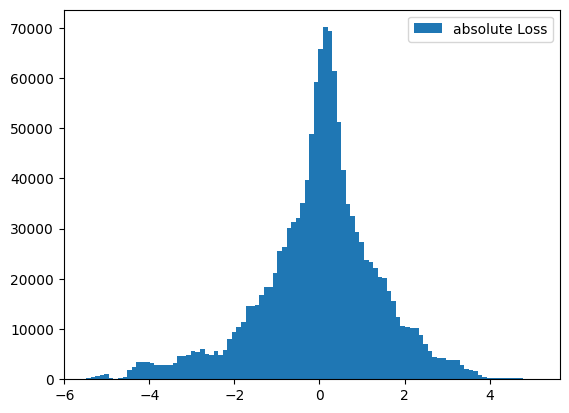

In [81]:
import matplotlib.pyplot as plt
min = np.min(abs_error)
max = np.max(abs_error)

bins = np.linspace(min, max, 100)

plt.hist(abs_error, bins, label='absolute Loss')
plt.legend(loc='upper right')
plt.show()